# Marketing Funnel Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0. 모듈 불러오기

In [ ]:
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
import graphviz

# 모델링
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 1. 데이터 수집

In [ ]:
# Load datasets
closed_deals = pd.read_csv("/content/drive/MyDrive/머신러닝 24-1/archive/olist_closed_deals_dataset.csv")
lead = pd.read_csv("/content/drive/MyDrive/머신러닝 24-1/archive/olist_marketing_qualified_leads_dataset.csv")

## 2. 데이터 전처리

### 2-1. 데이터셋 확인

In [ ]:
# 거래 성사된 데이터(전환 완료된 데이터)
closed_deals.head()

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,NaN,NaN,NaN,reseller,NaN,0.0
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,NaN,NaN,NaN,NaN,reseller,NaN,0.0
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,NaN,NaN,NaN,manufacturer,NaN,0.0


In [ ]:
# 잠재고객 데이터
# - 랜딩 페이지를 클릭하여 관심을 보인 사람을 잠재고객이라고 칭함
lead.head()

,mql_id,first_contact_date,landing_page_id,origin
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search
3,6be030b81c75970747525b843c1ef4f8,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search


### 2-2. 데이터셋 전처리

In [ ]:
# mql_id를 기준으로 데이터 병합
data = lead.merge(closed_deals, on='mql_id', how='left')
data.head()

,mql_id,first_contact_date,landing_page_id,origin,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6be030b81c75970747525b843c1ef4f8,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   mql_id                         8000 non-null   object 
 1   first_contact_date             8000 non-null   object 
 2   landing_page_id                8000 non-null   object 
 3   origin                         7940 non-null   object 
 4   seller_id                      842 non-null    object 
 5   sdr_id                         842 non-null    object 
 6   sr_id                          842 non-null    object 
 7   won_date                       842 non-null    object 
 8   business_segment               841 non-null    object 
 9   lead_type                      836 non-null    object 
 10  lead_behaviour_profile         665 non-null    object 
 11  has_company                    63 non-null     object 
 12  has_gtin                       64 non-null     o

In [ ]:
# 데이터 타입 변경
data["first_contact_date"] = pd.to_datetime(data["first_contact_date"])
data["won_date"] = pd.to_datetime(data["won_date"])

# 데이터 컬럼 추가 : 전환되는 데 얼마나 소요되는지
data["days_to_convert"] = (data["won_date"] - data["first_contact_date"]).dt.days

In [ ]:
# data.to_csv('funnel_data2.csv')

## 3. EDA

잠재고객 수와 어떤 유형으로 분류 되는지

In [ ]:
# 잠재고객 수 - 랜딩 페이지를 클릭한 사람의 수
data['mql_id'].nunique()

8000

In [ ]:
# 잠재고객
# online_top > online_big > online_medium > online_small > online_beginner
# 왼쪽으로 갈 수록 가장 큰 트래픽이나 매출을 기록하는 잠재고객유형이며, 오른쪽으로 갈 수록 이제 막 진입한 잠재고객임
# offline은 이벤트,전시회,촉판 등을 통해 확보된 잠재고객이며, industry는 특정 산업에 특화된 기업 또는 비즈니스에서 발생한 잠재고객을 의미함
data['lead_type'].value_counts()

lead_type
online_medium      332
online_big         126
industry           123
offline            104
online_small        77
online_beginner     57
online_top          14
other                3
Name: count, dtype: int64

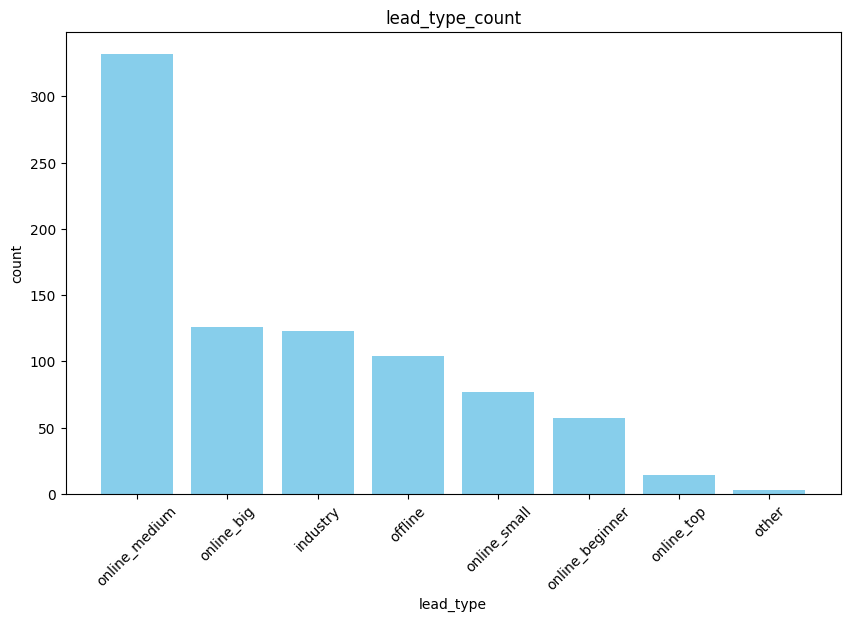

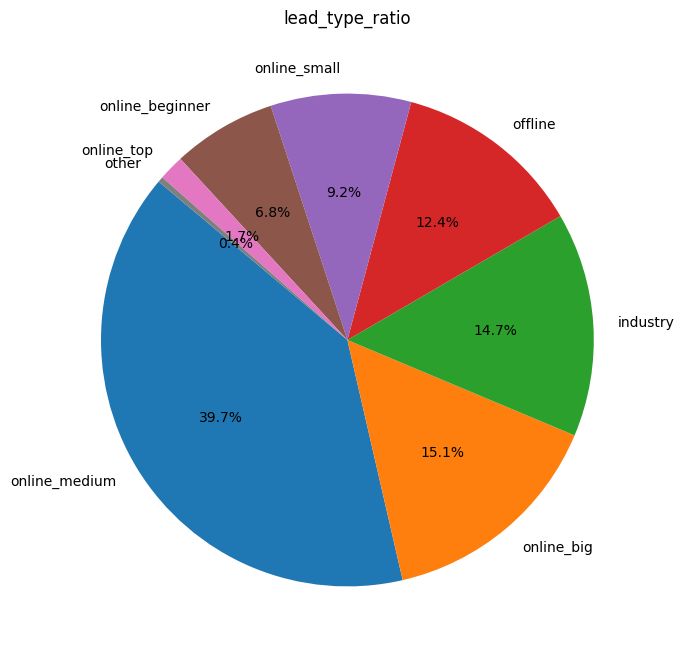

In [ ]:
# 데이터
labels = ['online_medium', 'online_big', 'industry', 'offline', 'online_small', 'online_beginner', 'online_top', 'other']
values = [332, 126, 123, 104, 77, 57, 14, 3]

# 막대 그래프
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='skyblue')
plt.xlabel('lead_type')
plt.ylabel('count')
plt.title('lead_type_count')
plt.xticks(rotation=45)
plt.show()

# 파이 차트
plt.figure(figsize=(8, 8))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('lead_type_ratio')
plt.show()

### 3-1. Marketing Channel Effectiveness

 #### 3-1-1. Marketing Channel Effectiveness: Leads

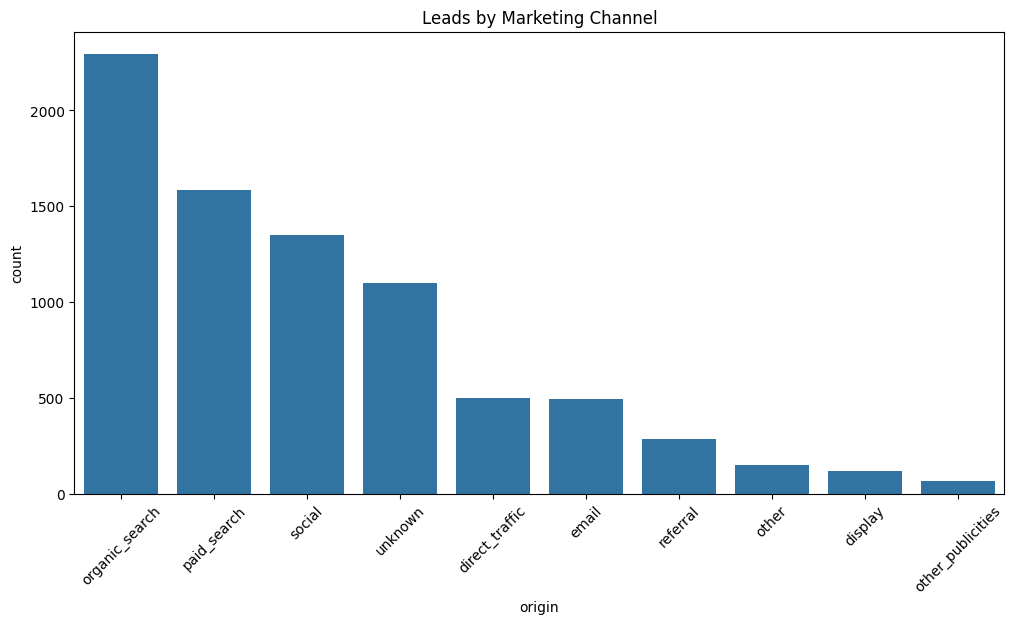

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='origin', order=data['origin'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Leads by Marketing Channel')
plt.show()

#### 3-1-2. Marketing Channel Effectiveness: Converts

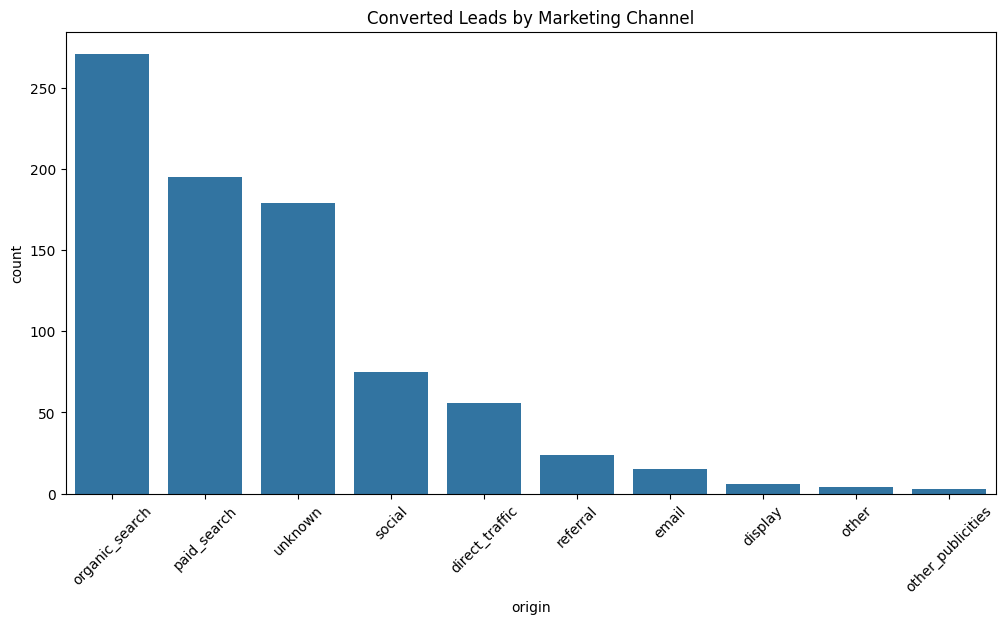

In [ ]:
# Filter the data to include only converted leads
converted_data = data[data['won_date'].notnull()]

# Plot the countplot for converted leads by marketing channel
plt.figure(figsize=(12, 6))
sns.countplot(data=converted_data, x='origin', order=converted_data['origin'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Converted Leads by Marketing Channel')
plt.show()


#### 3-1-3. Marketing Channel Effectiveness: Conversion Rate

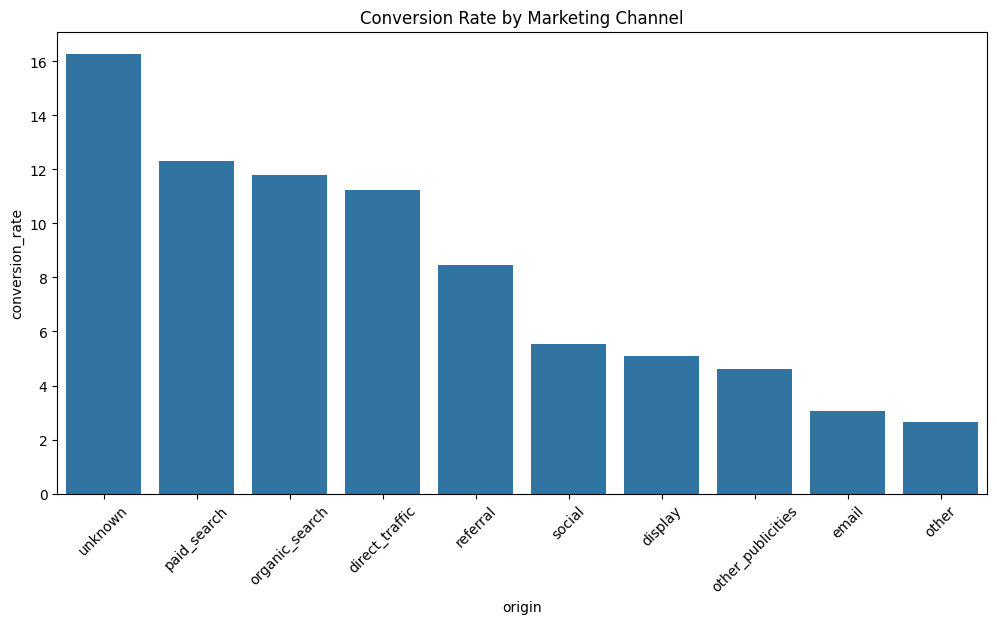

In [ ]:
# Count the leads by marketing channel
leads_by_channel = data['origin'].value_counts()

# Count the converted leads by marketing channel
converted_leads_by_channel = converted_data['origin'].value_counts()

# Calculate the conversion rate by marketing channel
conversion_rate_by_channel = (converted_leads_by_channel / leads_by_channel) * 100

# Reset index and rename columns
conversion_rate_by_channel = conversion_rate_by_channel.reset_index()
conversion_rate_by_channel.columns = ['origin', 'conversion_rate']

# Plot the conversion rate by marketing channel
plt.figure(figsize=(12, 6))
sns.barplot(data=conversion_rate_by_channel, x='origin', y='conversion_rate', order=conversion_rate_by_channel.sort_values('conversion_rate', ascending=False)['origin'])
plt.xticks(rotation=45)
plt.title('Conversion Rate by Marketing Channel')
plt.show()


### 3-2. MQL Customer Persona

#### 3-2-1. MQL Customer Persona: Lead Profile Count

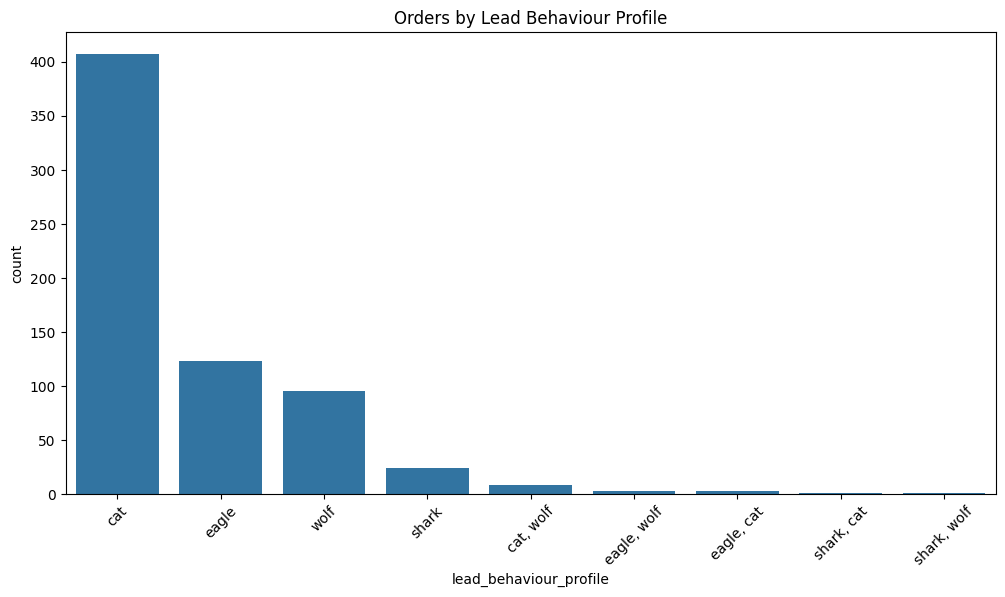

In [ ]:
# Who orders more?
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='lead_behaviour_profile', order=data['lead_behaviour_profile'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Orders by Lead Behaviour Profile')
plt.show()

# Who pays more? - Since the payment data is not available in this dataset, we cannot calculate the payment by each lead.


In [ ]:
# Average days_to_convert
print(f"Average Time to Buy: {data['days_to_convert'].mean()} days")


Average Time to Buy: 48.44061757719715 days


#### 3-2-2. MQL Customer Persona: Lead Profile by Business segment

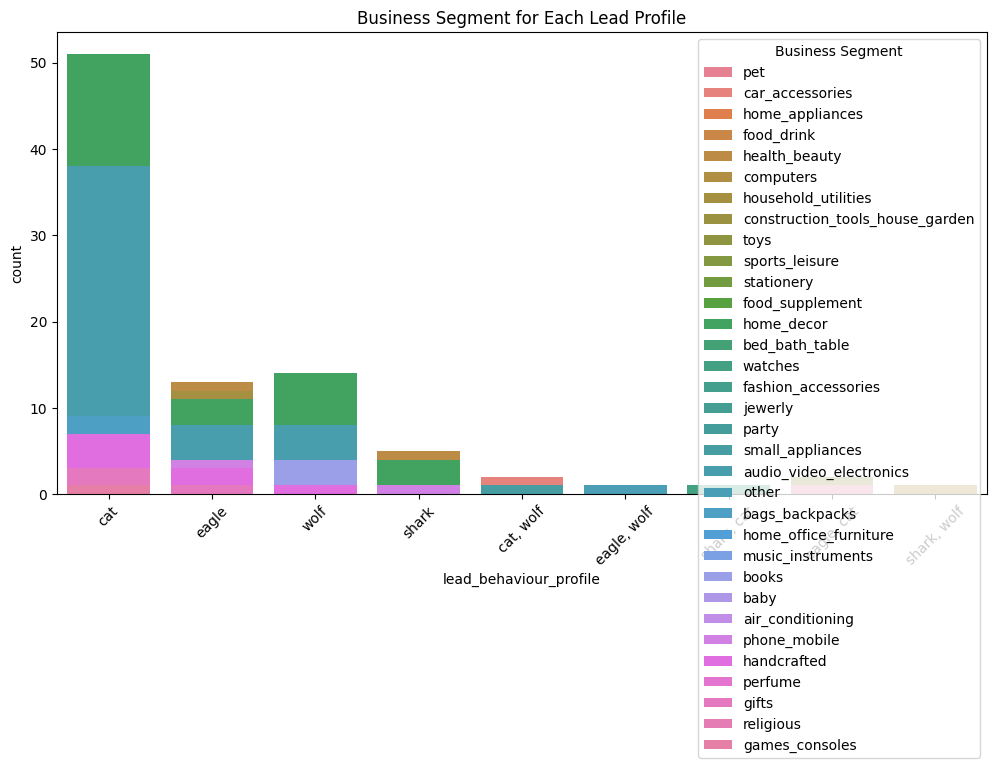

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='lead_behaviour_profile', hue='business_segment', dodge=False)
plt.xticks(rotation=45)
plt.title('Business Segment for Each Lead Profile')
plt.legend(loc='upper right', title='Business Segment')
plt.show()


#### 3-2-3. MQL Customer Persona: Win Rate by Lead Profile

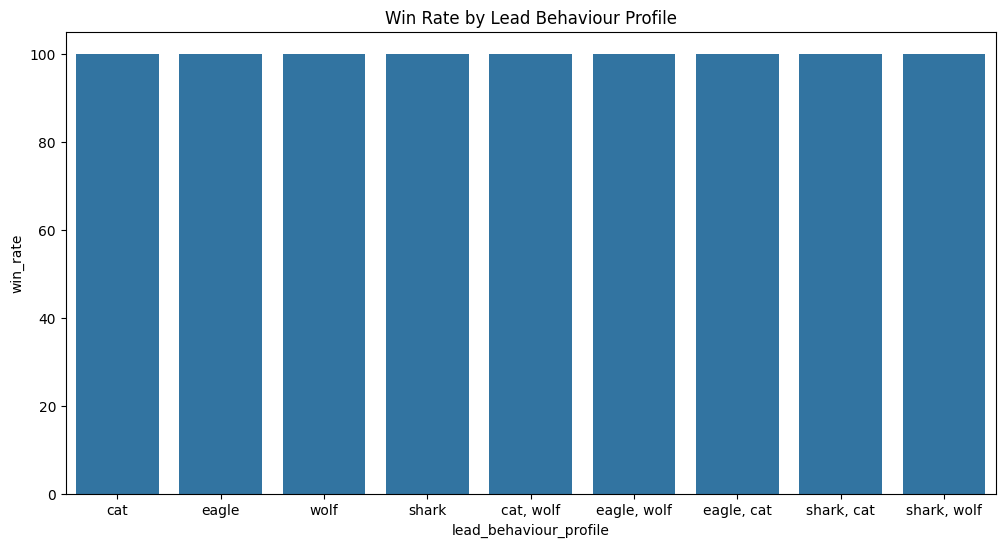

In [ ]:
# Count the leads by lead_behaviour_profile
leads_by_lead_profile = data['lead_behaviour_profile'].value_counts()

# Count the converted leads by lead_behaviour_profile
converted_leads_by_lead_profile = converted_data['lead_behaviour_profile'].value_counts()

# Calculate the win rate by lead_behaviour_profile
win_rate_lead_profile = (converted_leads_by_lead_profile / leads_by_lead_profile) * 100

# Reset index and rename columns
win_rate_lead_profile = win_rate_lead_profile.reset_index()
win_rate_lead_profile.columns = ['lead_behaviour_profile', 'win_rate']

# Plot the win rate by lead_behaviour_profile
plt.figure(figsize=(12, 6))
sns.barplot(data=win_rate_lead_profile, x='lead_behaviour_profile', y='win_rate', order=win_rate_lead_profile.sort_values('win_rate', ascending=False)['lead_behaviour_profile'])
plt.title('Win Rate by Lead Behaviour Profile')
plt.show()

In [ ]:
leads_by_lead_profile.head()

lead_behaviour_profile
cat          407
eagle        123
wolf          95
shark         24
cat, wolf      8
Name: count, dtype: int64

### 3-3. Won Customer Persona

#### 3-3-1. Won Customer Persona: Sales won per month

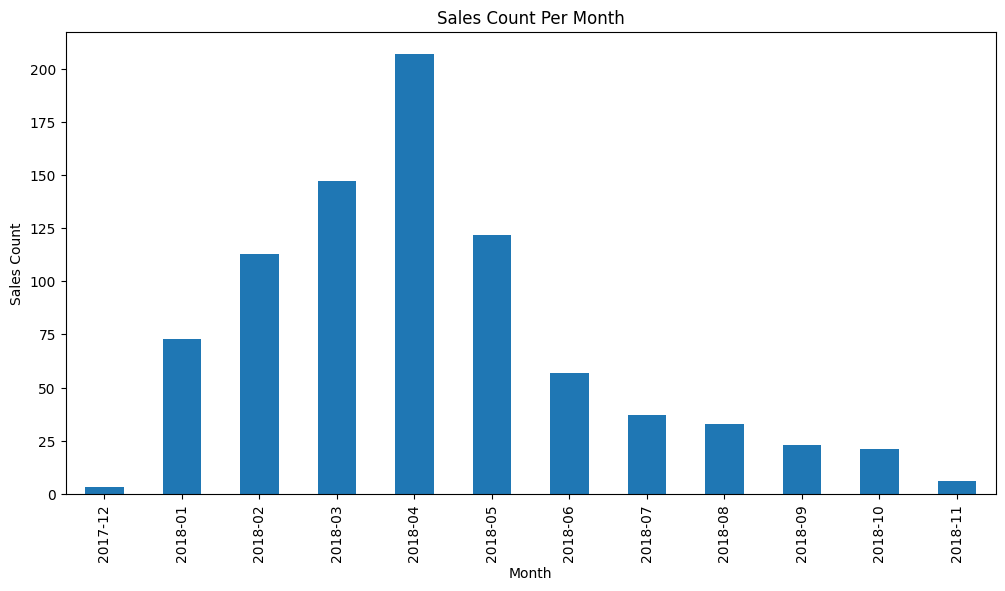

In [ ]:
data["won_month"] = data["won_date"].dt.to_period("M")
sales_count = data["won_month"].value_counts().sort_index()
sales_count.plot(kind='bar', figsize=(12, 6))
plt.title("Sales Count Per Month")
plt.xlabel("Month")
plt.ylabel("Sales Count")
plt.show()

#### 3-3-2. Won Customer Persona: Days to convert by channel

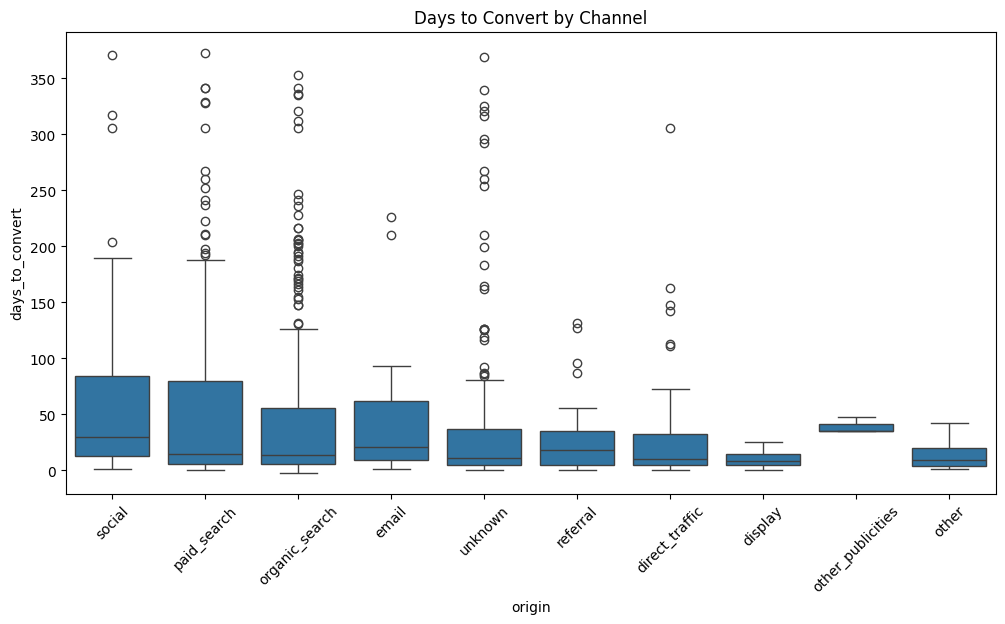

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='origin', y='days_to_convert')
plt.xticks(rotation=45)
plt.title('Days to Convert by Channel')
plt.show()


### 3-4. Seller Persona

#### 3-4-1. Seller Persona: Days to Convert

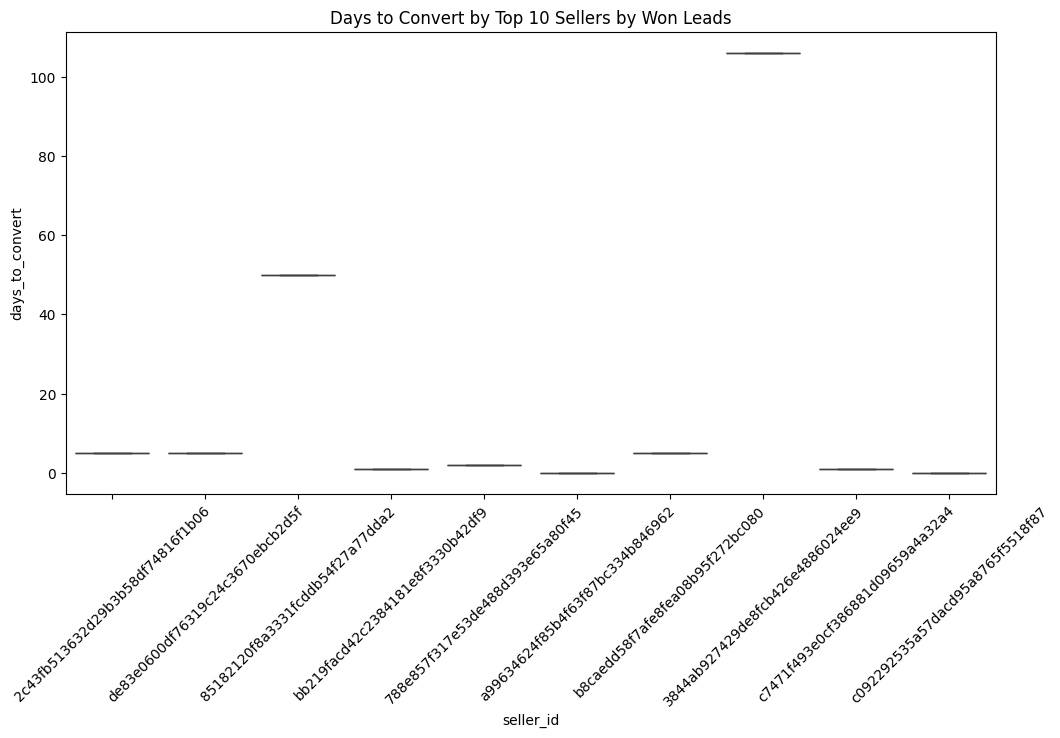

In [ ]:
# Find the top 10 sellers with the most won leads
top_10_sellers = converted_data["seller_id"].value_counts().head(10).index

# Filter the data for the top 10 sellers
top_10_sellers_data = data[data["seller_id"].isin(top_10_sellers)]

# Plot the boxplot for the top 10 sellers
plt.figure(figsize=(12, 6))
sns.boxplot(data=top_10_sellers_data, x='seller_id', y='days_to_convert')
plt.xticks(rotation=45)
plt.title('Days to Convert by Top 10 Sellers by Won Leads')
plt.show()


#### 3-4-2. Seller Persona: Win rate by seller by channel:

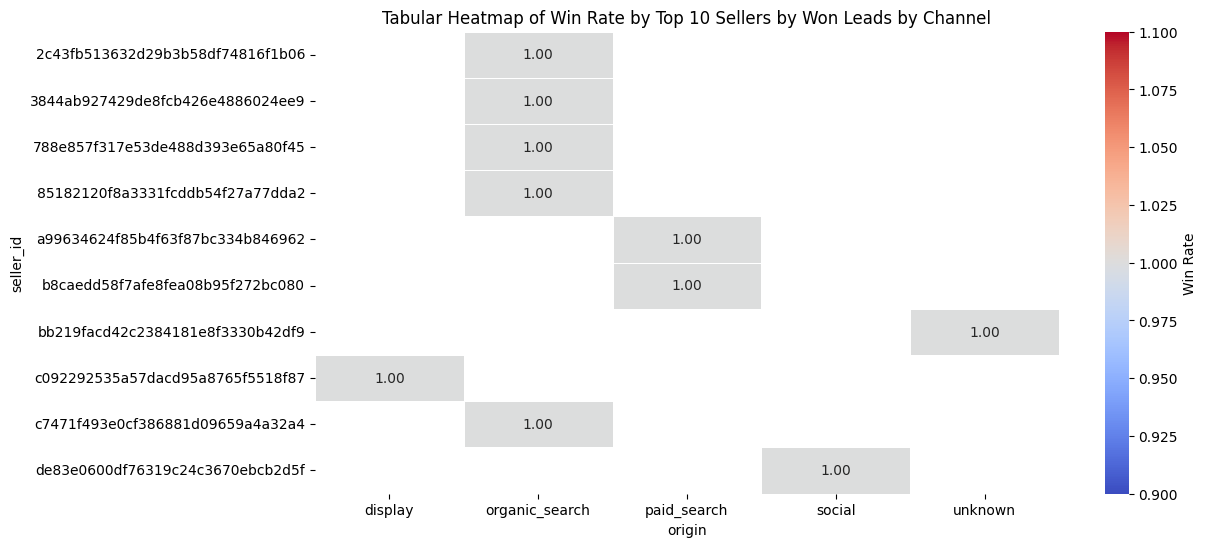

In [ ]:
# Calculate win rate by seller and channel
win_rate_seller_channel = data.groupby(['seller_id', 'origin'])['won_date'].agg(lambda x: x.notnull().sum() / len(x)).reset_index()
win_rate_seller_channel.rename(columns={'won_date': 'win_rate'}, inplace=True)

# Find the top 10 sellers with the most won leads
top_10_sellers = converted_data["seller_id"].value_counts().head(10).index

# Filter the win_rate_seller_channel for the top 10 sellers
top_10_sellers_win_rate = win_rate_seller_channel[win_rate_seller_channel["seller_id"].isin(top_10_sellers)]

# Pivot the data for the heatmap
heatmap_data = top_10_sellers_win_rate.pivot_table(index='seller_id', columns='origin', values='win_rate')

# Plot the tabular heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={'label': 'Win Rate'})
plt.title('Tabular Heatmap of Win Rate by Top 10 Sellers by Won Leads by Channel')
plt.show()

#### 3-4-3. Seller Persona: Win rate by seller by business segment:

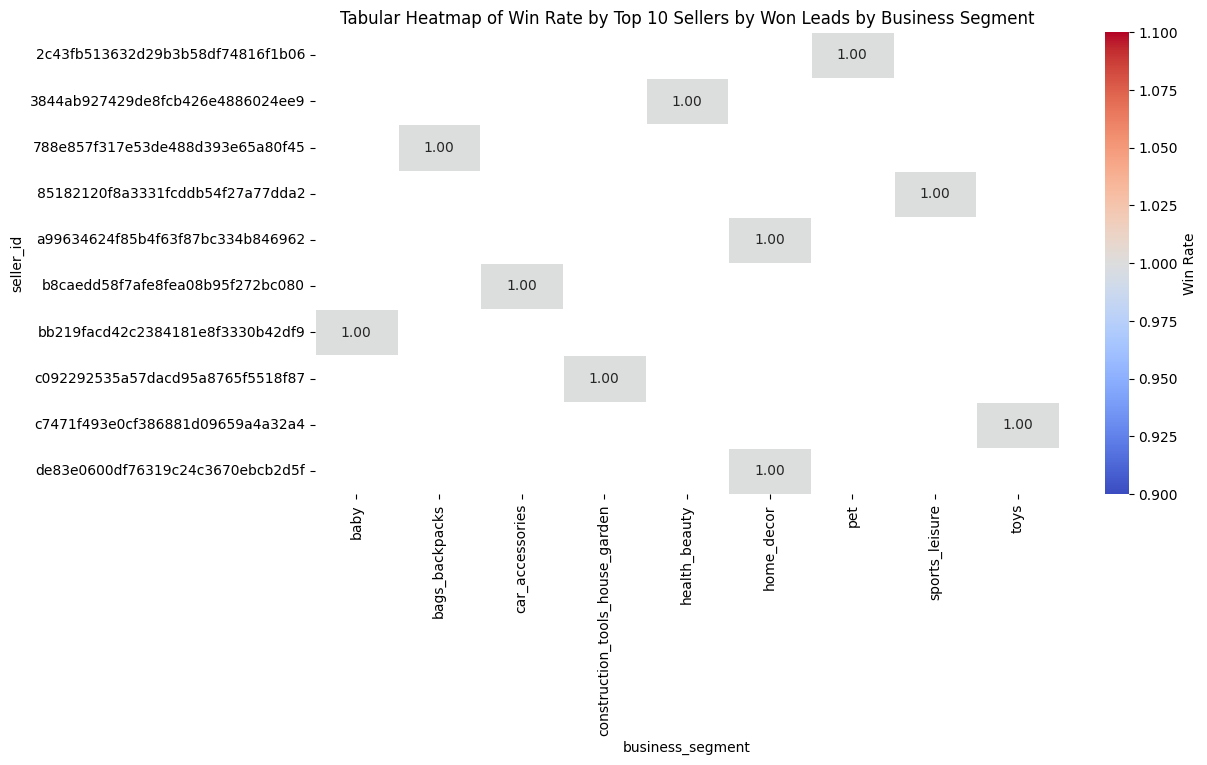

In [ ]:
# Calculate win rate by seller and business segment
win_rate_seller_segment = data.groupby(['seller_id', 'business_segment'])['won_date'].agg(lambda x: x.notnull().sum() / len(x)).reset_index()
win_rate_seller_segment.rename(columns={'won_date': 'win_rate'}, inplace=True)

# Find the top 10 sellers with the most won leads
top_10_sellers = converted_data["seller_id"].value_counts().head(10).index

# Filter the win_rate_seller_segment for the top 10 sellers
top_10_sellers_win_rate_segment = win_rate_seller_segment[win_rate_seller_segment["seller_id"].isin(top_10_sellers)]

# Pivot the data for the heatmap
heatmap_data = top_10_sellers_win_rate_segment.pivot_table(index='seller_id', columns='business_segment', values='win_rate')

# Plot the tabular heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={'label': 'Win Rate'})
plt.title('Tabular Heatmap of Win Rate by Top 10 Sellers by Won Leads by Business Segment')
plt.show()


#### 3-4-4. Seller Persona: Win rate by seller by lead_type:

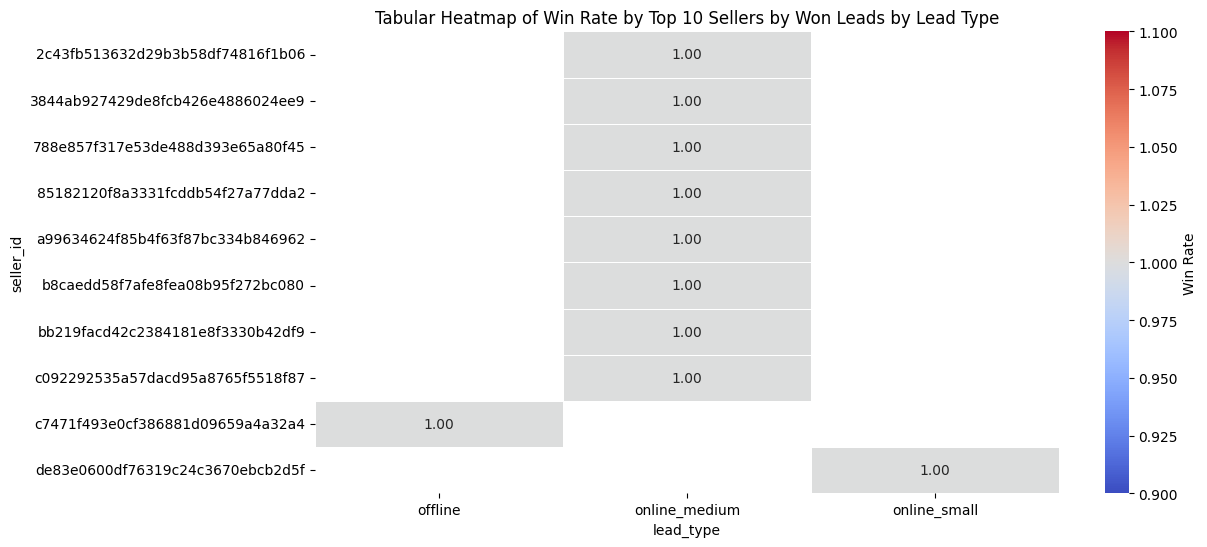

In [ ]:
# Calculate win rate by seller and lead type
win_rate_seller_lead_type = data.groupby(['seller_id', 'lead_type'])['won_date'].agg(lambda x: x.notnull().sum() / len(x)).reset_index()
win_rate_seller_lead_type.rename(columns={'won_date': 'win_rate'}, inplace=True)

# Find the top 10 sellers with the most won leads
top_10_sellers = converted_data["seller_id"].value_counts().head(10).index

# Filter the win_rate_seller_lead_type for the top 10 sellers
top_10_sellers_win_rate_lead_type = win_rate_seller_lead_type[win_rate_seller_lead_type["seller_id"].isin(top_10_sellers)]

# Pivot the data for the heatmap
heatmap_data = top_10_sellers_win_rate_lead_type.pivot_table(index='seller_id', columns='lead_type', values='win_rate')

# Plot the tabular heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={'label': 'Win Rate'})
plt.title('Tabular Heatmap of Win Rate by Top 10 Sellers by Won Leads by Lead Type')
plt.show()

#### 3-4-5. Seller Persona: Win rate by seller by lead_behaviour_profile:

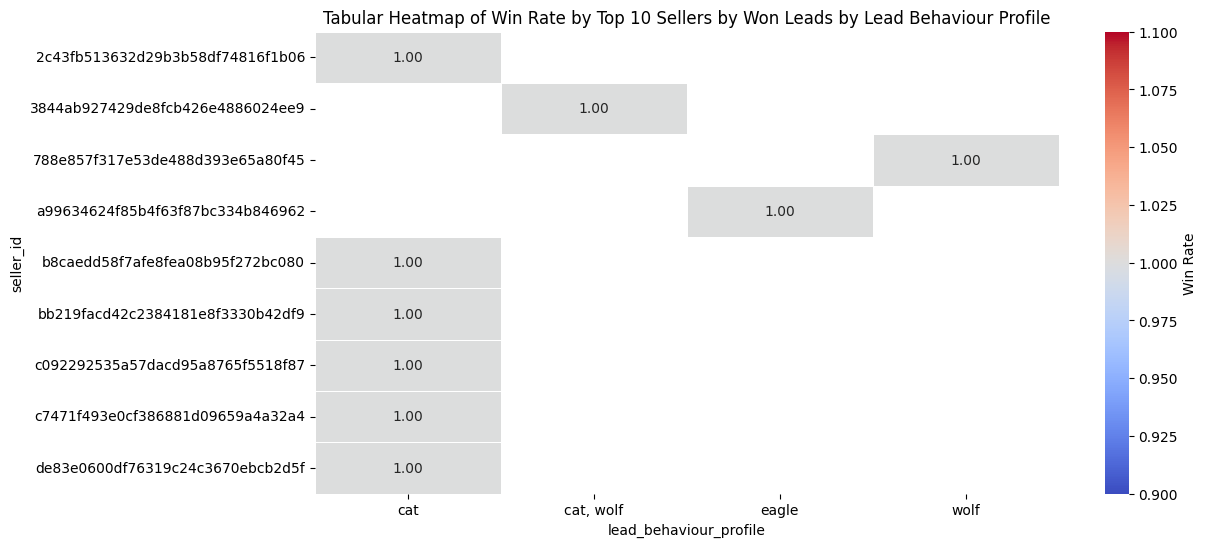

In [ ]:
# Calculate win rate by seller and lead behavior profile
win_rate_seller_lead_profile = data.groupby(['seller_id', 'lead_behaviour_profile'])['won_date'].agg(lambda x: x.notnull().sum() / len(x)).reset_index()
win_rate_seller_lead_profile.rename(columns={'won_date': 'win_rate'}, inplace=True)

# Find the top 10 sellers with the most won leads
top_10_sellers = converted_data["seller_id"].value_counts().head(10).index

# Filter the win_rate_seller_lead_profile for the top 10 sellers
top_10_sellers_win_rate_lead_profile = win_rate_seller_lead_profile[win_rate_seller_lead_profile["seller_id"].isin(top_10_sellers)]

# Pivot the data for the heatmap
heatmap_data = top_10_sellers_win_rate_lead_profile.pivot_table(index='seller_id', columns='lead_behaviour_profile', values='win_rate')

# Plot the tabular heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={'label': 'Win Rate'})
plt.title('Tabular Heatmap of Win Rate by Top 10 Sellers by Won Leads by Lead Behaviour Profile')
plt.show()

### 3-5. Landing Page

#### 3-5-1. Landing Page: Days to convert for the top 10 landing page:

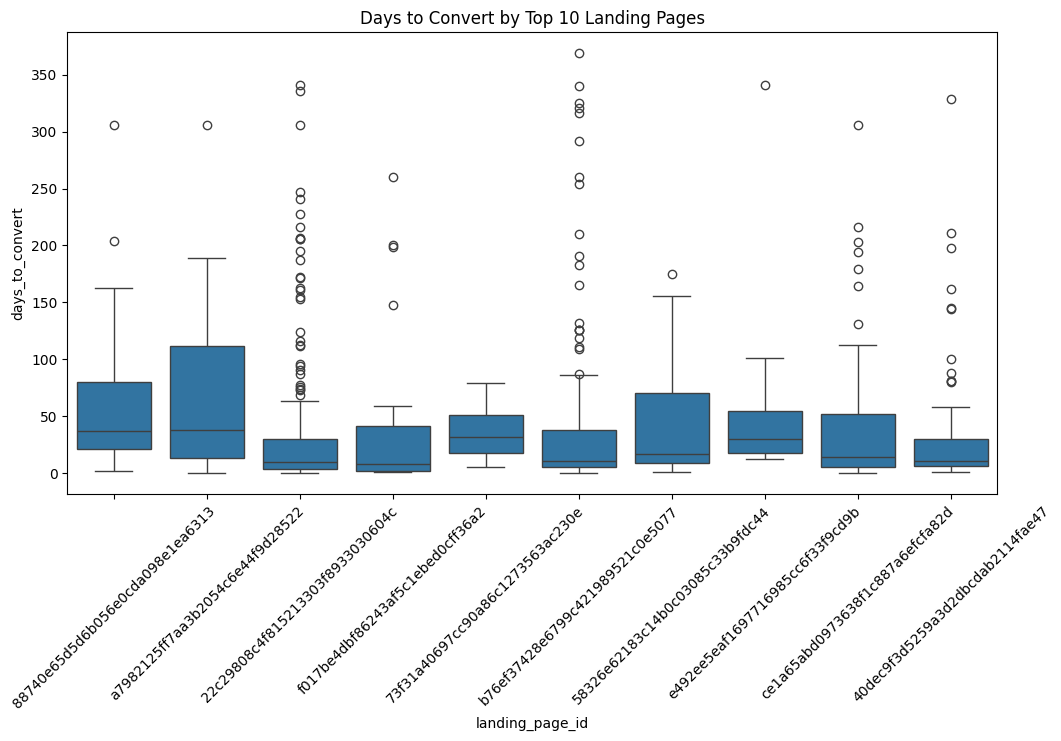

In [ ]:
# Find the top 10 most visited landing_page_id
top_10_landing_pages = data["landing_page_id"].value_counts().head(10).index

# Filter the data for the top 10 most visited landing_page_id
top_10_data = data[data["landing_page_id"].isin(top_10_landing_pages)]

# Plot the boxplot for the top 10 landing_page_id
plt.figure(figsize=(12, 6))
sns.boxplot(data=top_10_data, x='landing_page_id', y='days_to_convert')
plt.xticks(rotation=45)
plt.title('Days to Convert by Top 10 Landing Pages')
plt.show()


#### 3-5-2. Top landing pages by frequency

<ipython-input-47-1ef22c02d4dc>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filtered_data, x='landing_page_id', palette='viridis')


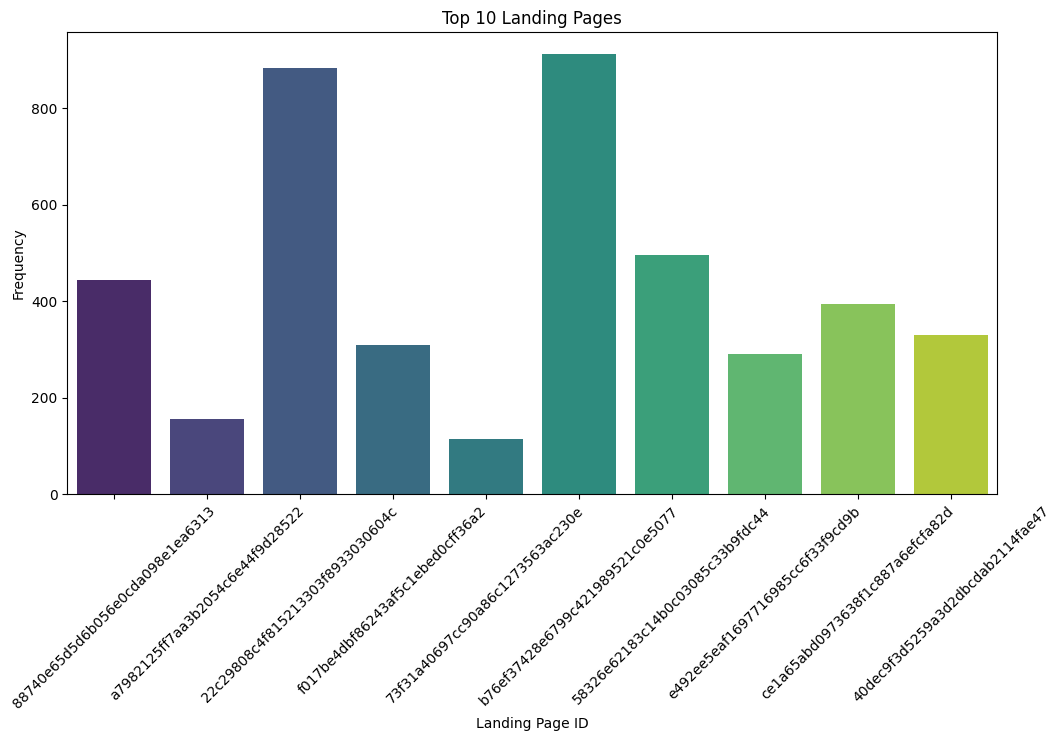

In [ ]:
# Filter dataset to only include top 10 landing pages
top_landing_pages = data['landing_page_id'].value_counts().head(10).index
filtered_data = data[data['landing_page_id'].isin(top_landing_pages)]


plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_data, x='landing_page_id', palette='viridis')
plt.title('Top 10 Landing Pages')
plt.xlabel('Landing Page ID')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


#### 3-5-3. Landing page distribution by lead origin

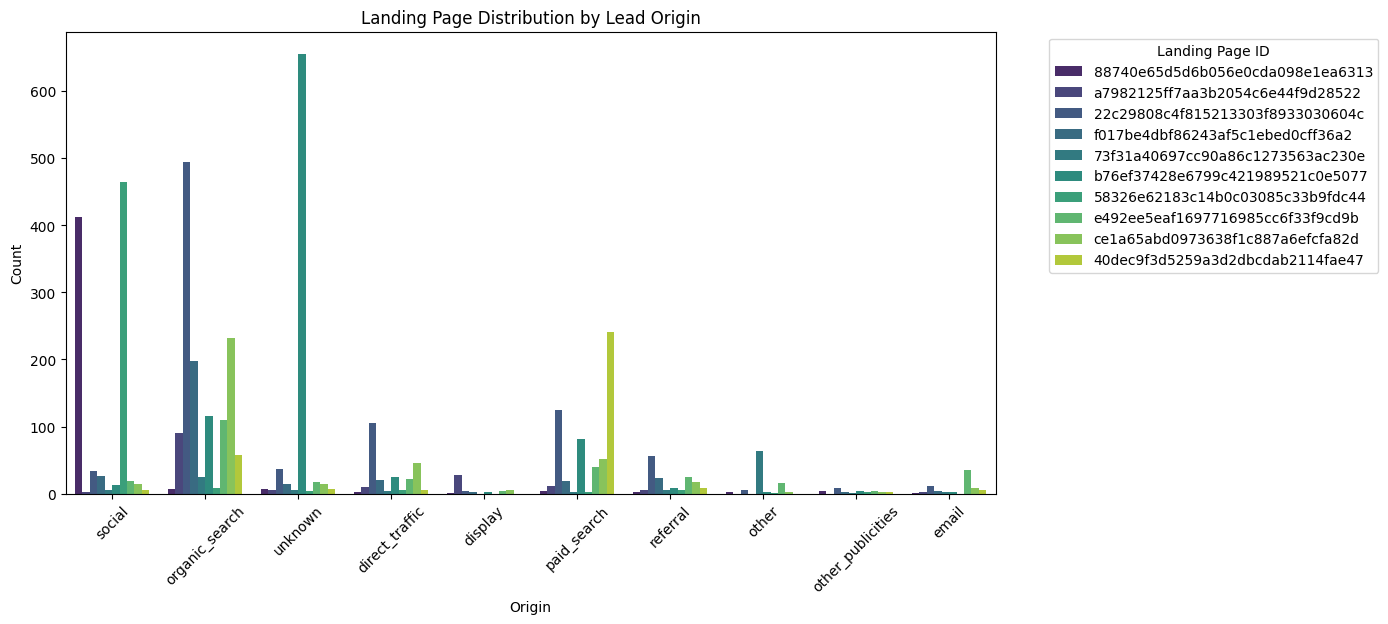

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_data, x='origin', hue='landing_page_id', palette='viridis')
plt.title('Landing Page Distribution by Lead Origin')
plt.xlabel('Origin')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Landing Page ID', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.show()

#### 3-5-4. Landing page distribution by business segment

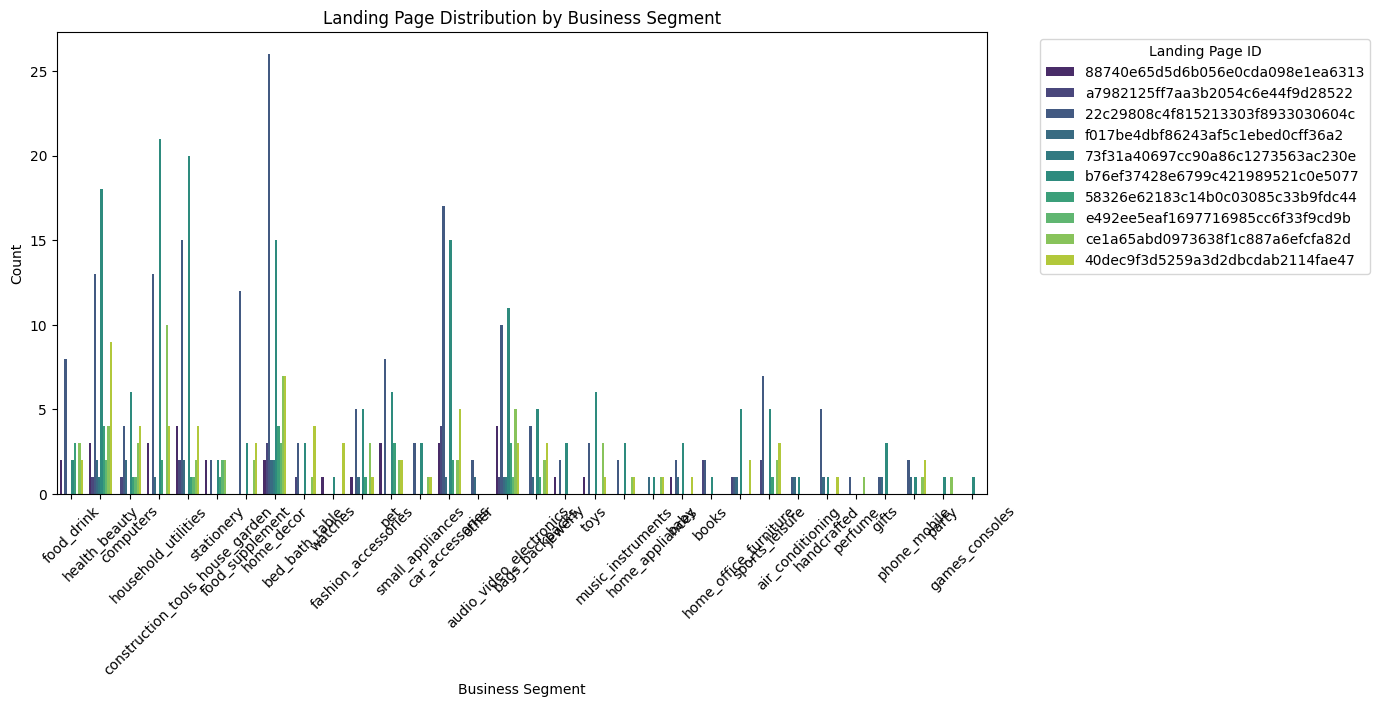

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_data, x='business_segment', hue='landing_page_id', palette='viridis')
plt.title('Landing Page Distribution by Business Segment')
plt.xlabel('Business Segment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Landing Page ID', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.show()

#### 3-5-5. Landing page distribution by lead type

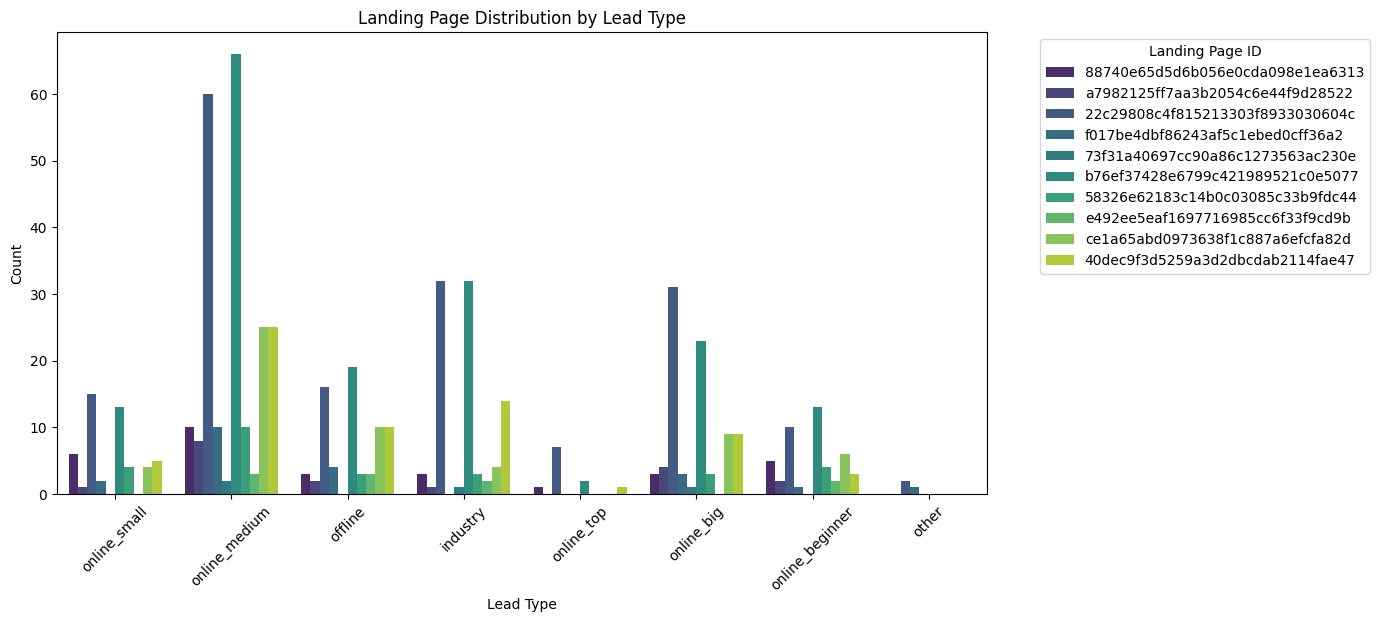

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_data, x='lead_type', hue='landing_page_id', palette='viridis')
plt.title('Landing Page Distribution by Lead Type')
plt.xlabel('Lead Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Landing Page ID', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.show()


### 3-6.

#### 3-6-1. Relationship between declared_product_catalog_size and declared_monthly_revenue

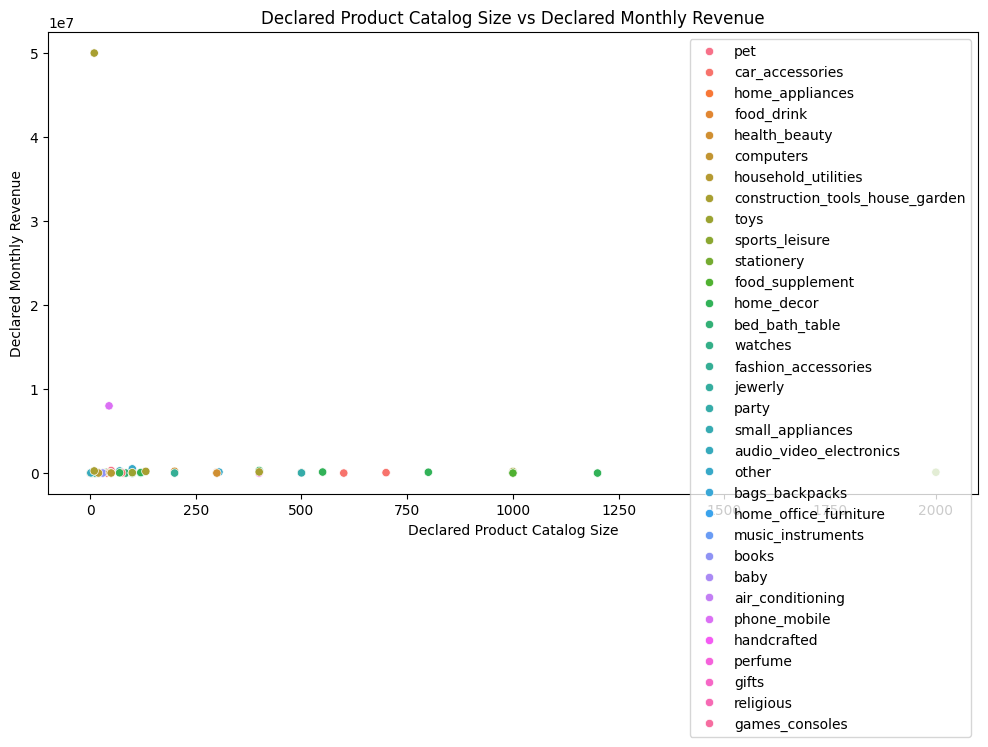

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='declared_product_catalog_size', y='declared_monthly_revenue', hue='business_segment')
plt.title('Declared Product Catalog Size vs Declared Monthly Revenue')
plt.xlabel('Declared Product Catalog Size')
plt.ylabel('Declared Monthly Revenue')
plt.legend(loc='upper right')
plt.show()


#### 3-6-2. Most common business types

<ipython-input-52-7f3de8927cb9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='business_type', palette='viridis')


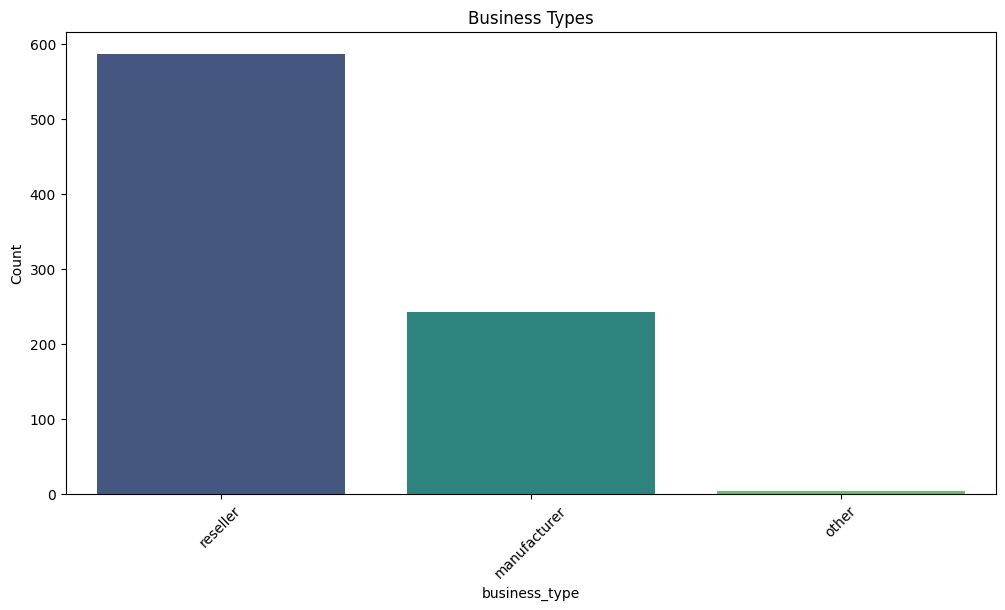

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='business_type', palette='viridis')
plt.title('Business Types')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


#### 3-6-3. Distribution of average_stock

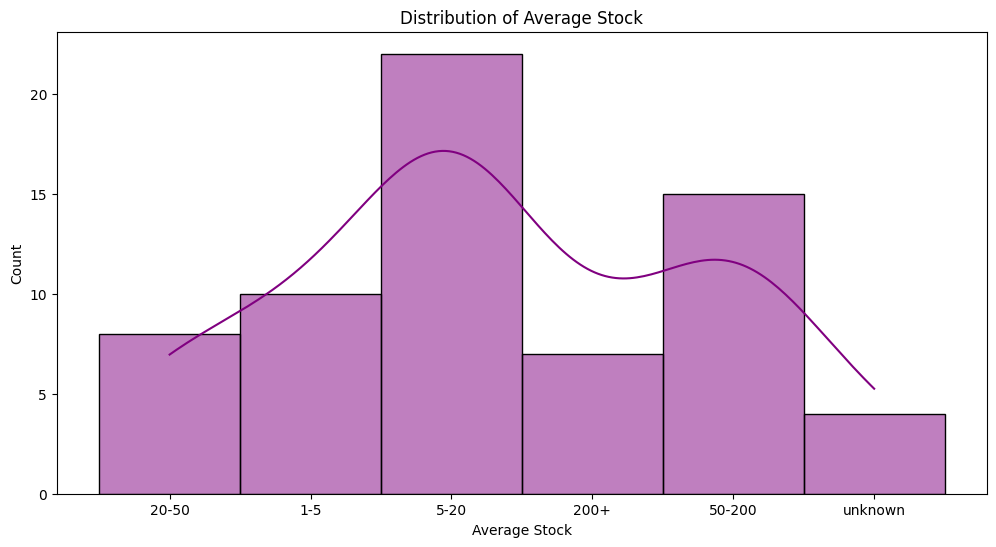

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='average_stock', bins=50, kde=True, color='purple')
plt.title('Distribution of Average Stock')
plt.xlabel('Average Stock')
plt.ylabel('Count')
plt.show()


#### 3-6-4. Leads with company or GTIN information


<ipython-input-54-213b6a9e0dc8>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='has_company', palette='viridis')


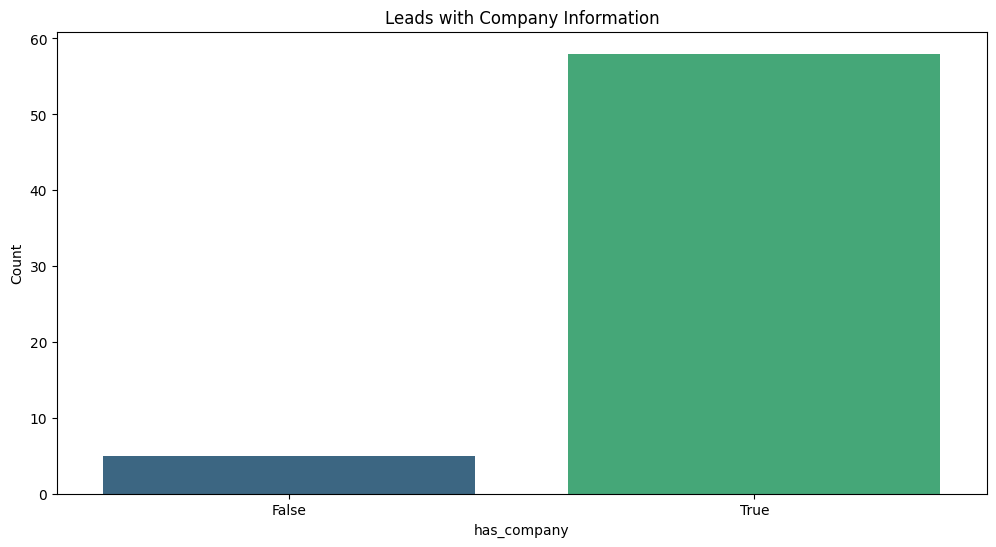

<ipython-input-54-213b6a9e0dc8>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='has_gtin', palette='viridis')


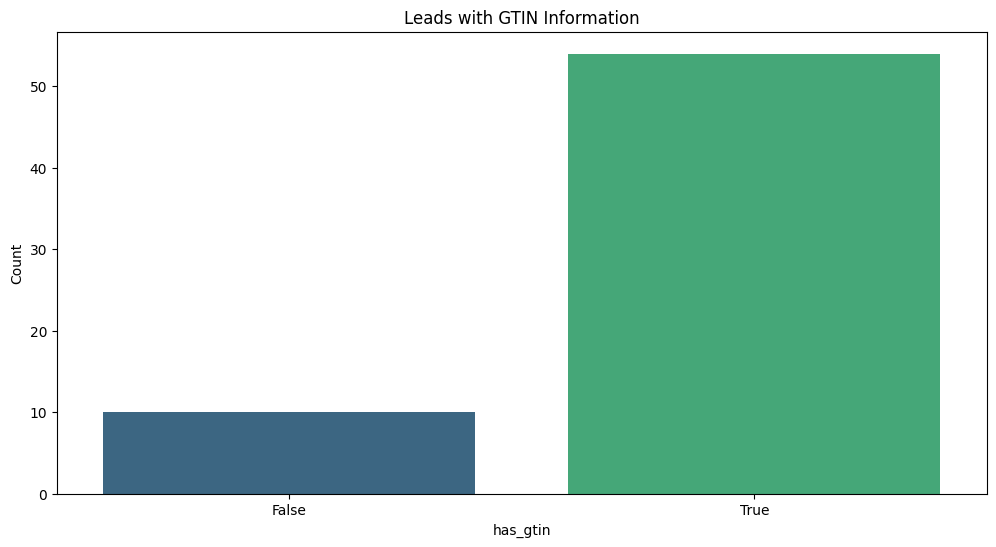

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='has_company', palette='viridis')
plt.title('Leads with Company Information')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='has_gtin', palette='viridis')
plt.title('Leads with GTIN Information')
plt.ylabel('Count')
plt.show()


## 4. 모델링

In [ ]:
df = pd.read_csv("funnel_merge.csv")

In [ ]:
df.drop(columns=['customer_unique_id', 'customer_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'order_id', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date','customer_city', 'customer_zip_code_prefix', 'customer_state', 'seller_zip_code_prefix', 'shipping_limit_date', 'order_item_id', 'product_id', 'seller_id', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'product_id', 'seller_id', 'shipping_limit_date', 'sr_id', 'sdr_id', 'landing_page_id', 'mql_id', 'seller_state', 'seller_city', 'seller_zip_code_prefix', 'order_item_id', 'first_contact_date', 'won_date'], inplace=True)

### Feature Categorization
#### LabelEncoding & OneHotEncoding

In [ ]:
categorical_features = ['order_status', 'delivery_status', '결제_유형', 'business_segment', 'lead_behaviour_profile', 'has_company', 'has_gtin', 'average_stock', 'business_type']

label_encoder = LabelEncoder()
for feature in categorical_features:
    if feature in df.columns:
        df[feature] = label_encoder.fit_transform(df[feature].astype(str))

onehot_encoder = OneHotEncoder(sparse=False)
for feature in categorical_features:
    if feature in df.columns:
        encoded_columns = onehot_encoder.fit_transform(df[[feature]])
        encoded_df = pd.DataFrame(encoded_columns, columns=onehot_encoder.get_feature_names_out([feature]))
        df = pd.concat([df.drop(columns=[feature]), encoded_df], axis=1)

print(df.head())

In [ ]:
df.drop(columns=['review_id', 'declared_product_catalog_size', 'review_score'], inplace=True)
df.dropna(subset=['delivery_period'], inplace=True)

In [ ]:
label_encoder = LabelEncoder()

df['lead_type_encoded'] = label_encoder.fit_transform(df['lead_type'])

print(label_encoder.classes_)

In [ ]:
df.drop(columns=['lead_type'], inplace=True)

In [ ]:
df = pd.get_dummies(df, columns=['origin'])

### Correlation Matrix

In [ ]:
corr_matrix

### RandomForest

In [ ]:
rf_classifier = RandomForestClassifier()

X = df.drop(columns=['lead_type_encoded'])
y = df['lead_type_encoded']

rf_classifier.fit(X, y)

#### Feature Importance 

In [ ]:
feature_importances = rf_classifier.feature_importances_

indices = np.argsort(feature_importances)[::-1]

print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {X.columns[indices[f]]}: {feature_importances[indices[f]]}")

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), feature_importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

### Confusion Matrix Visualization
##### 특정 클래스(3,4에서 가장 예측이 잘되고 있다는 것)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

#### Importance > 0.02

In [ ]:
important_features = [X.columns[i] for i, importance in enumerate(feature_importances) if importance > 0.02]
print("Features with importance greater than 0.02:", important_features)

In [ ]:
features = ['delivery_period', 'price', 'freight_value', '지불_값', 'days_to_convert', 
            'business_segment_15', 'business_segment_19', 'business_segment_22', 
            'business_segment_28', 'lead_behaviour_profile_0', 'lead_behaviour_profile_4', 
            'origin_organic_search', 'origin_paid_search', 'origin_unknown']
target = 'lead_type_encoded'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nRanomForest Classification Report:")
print(classification_report(y_test, y_pred))

### Decision Tree

In [3]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

y_pred_tree = tree_model.predict(X_test)
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print("Decision Tree Accuracy:", accuracy_tree)

print("\nDecisionTree Classification Report:")
print(classification_report(y_test, y_pred_tree))

NameError: name 'DecisionTreeClassifier' is not defined

### Decision Tree Visualization

In [ ]:
class_names = [str(label) for label in y.unique()]

dot_data = export_graphviz(tree_model, out_file=None, 
                           feature_names=X.columns,  
                           class_names=class_names,  
                           filled=True, rounded=True,  
                           special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("decision_tree")

graph

### Gradient Boosting

In [ ]:
gradient_boosting_model = GradientBoostingClassifier(random_state=42)
gradient_boosting_model.fit(X_train, y_train)

y_pred_gradient_boosting = gradient_boosting_model.predict(X_test)
accuracy_gradient_boosting = accuracy_score(y_test, y_pred_gradient_boosting)
print("GradientBoosting Model Accuracy:", accuracy_gradient_boosting)

print("\GradientBoosting Classification Report:")
print(classification_report(y_test, y_pred_gradient_boosting))

### Gradient Boosting Learning Curves

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(gradient_boosting_model, X_train, y_train, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()


### XGBoost

In [ ]:
xgboost_model = XGBClassifier(random_state=42)
xgboost_model.fit(X_train, y_train)

y_pred_xgboost = xgboost_model.predict(X_test)
accuracy_xgboost = accuracy_score(y_test, y_pred_xgboost)
print("XGBoost Model Accuracy:", accuracy_xgboost)

print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgboost))

### Overfitting 너무 심해서 시각화 자료가 의미가 없음 ..